In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


In [ ]:
df =  pd.read_csv("https://raw.githubusercontent.com/FabioGagliardiIts/datasets/main/dati_prenotazioni.csv")

display(df)

,Unnamed: 0,prenotazioni,pizze,eventi bar
0,0,50,56,1
1,1,83,95,0
2,2,71,80,0
3,3,109,124,0
4,4,10,40,1
...,...,...,...,...
95,95,71,99,0
96,96,76,81,0
97,97,89,101,0
98,98,69,101,0


In [ ]:
prenotazioni = df['prenotazioni']
eventi = df['eventi bar']

Da una prima visualizzazione è chiaro che non è possibile usare direttamente un modello di Regressione Lineare.

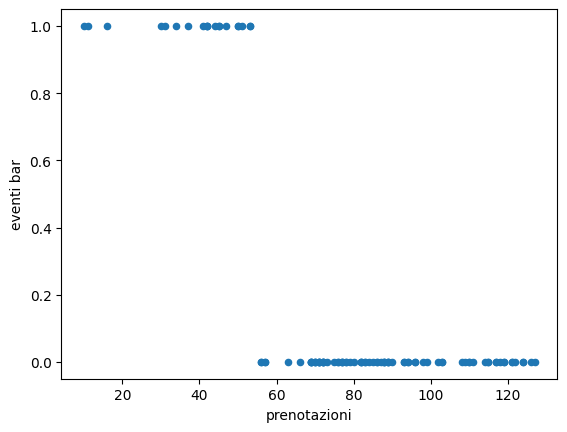

In [ ]:
df.plot.scatter(x="prenotazioni", y="eventi bar")
plt.show()

## **visuallizzazione dei dati**

Cerchiamo innanzitutto di trovare una buona visualizzazione che ci dia indicazioni su come si ditribuisce il dato delle prenotazioni rispetto agli eventi.

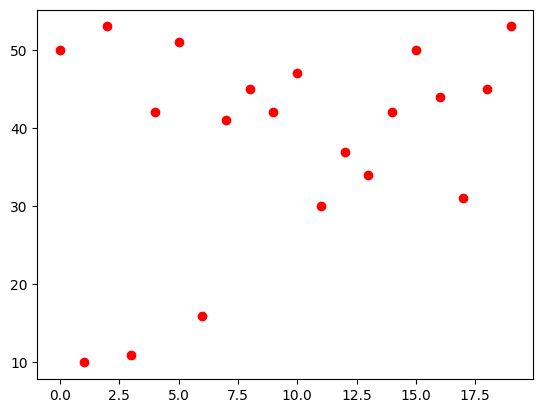

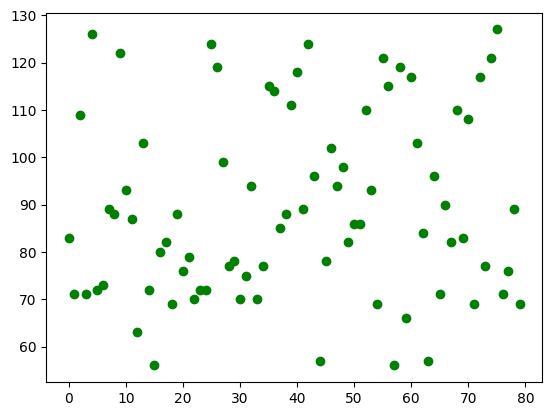

In [ ]:
# selezioniamo i dati
eventi_si = df['prenotazioni'][df['eventi bar'] == 1]
eventi_no = df['prenotazioni'][df['eventi bar'] == 0]

plt.scatter(np.arange(eventi_si.size), eventi_si, color='red')
plt.show()
plt.scatter(np.arange(eventi_no.size), eventi_no, color='green')
plt.show()


In [ ]:
print("EVENTI SI")
display(eventi_si.describe())
print("\n")
print("EVENTI NO")
display(eventi_no.describe())

EVENTI SI


count    20.00000
mean     38.70000
std      13.17134
min      10.00000
25%      33.25000
50%      42.00000
75%      47.75000
max      53.00000
Name: prenotazioni, dtype: float64



EVENTI NO


count     80.000000
mean      89.225000
std       19.528606
min       56.000000
25%       72.000000
50%       86.000000
75%      104.250000
max      127.000000
Name: prenotazioni, dtype: float64

Come risultato abbiamo ottenuto un'informazione molto importate: i dati sono separati da un valore soglia (**threshold**) che separa le prenotazioni in base al verificarsi o meno degli eventi.



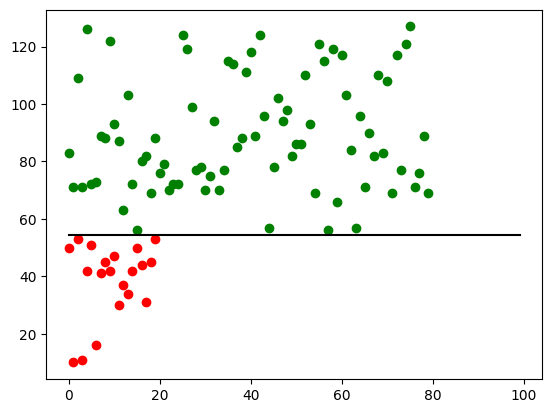

In [ ]:
plt.scatter(np.arange(eventi_si.size), eventi_si, color='red')
plt.plot(np.arange(100), np.full(100, 53 + (56. - 53.) / 2.), color='black')
plt.scatter(np.arange(eventi_no.size), eventi_no, color='green')
plt.show()

# **Le funzioni sigmoidee**

Dalla visualizzazione dei dati è chiaro che la risposta al nostro problema non potrebbe passare direttamente per un modello predittivo, tantomeno lineare, non ci interessa approssimare un valore atteso.

Abbiamo invece bisogno di una funzione non linenare che formalizzi l'appartenenza delle "features" ai gruppi formati dalle "labels.

La nostra funzione dovrà essere:
- continua, perchè per applicare la discesa del gradiente deve essere derivabile e non mostrare discontinuità
- compresa tra 0 e 1, perché dovrà rappresentare lo spazio di probablità all'interno del quale una variabile viene classificata.


In matematica una funzione del genere fa parte di quella famiglia di funzioni, dalla caratteristica forma ad "s", chiamate appunto funzioni sigmoidee. Nello specifico, per il nostro problema di classificazione, useremo quella che viene chiamata ***funzione logistica***.

Di seguito l'equazione che la caratterizza:
\begin{align}
  y = \frac{1}{1 + e^{-z}}
\end{align}

In [ ]:
def sigmoid(z: np.array):
  return 1 / (1 + np.exp(-z))

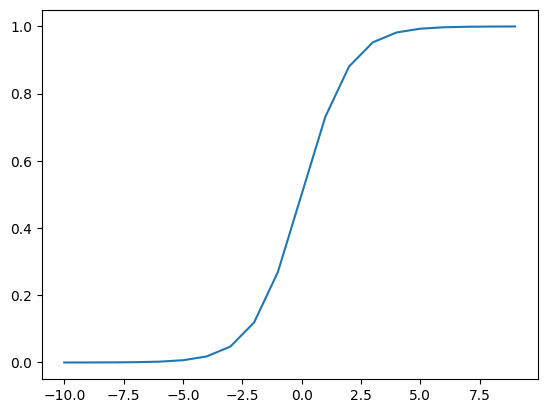

In [ ]:
sx = np.arange(-10, 10)
plt.plot(sx, sigmoid(sx))
plt.show()

Quindi per ogni valore "p" avremo una **classificazione binaria** data da:
\begin{align}
  p >= 0.5 : eventi bar = 1
\end{align}

\begin{align}
  p < 0.5 : eventi bar = 0
\end{align}

# **Classificazione**


Abbiamo definito la funzione che ci definisce lo spazio di probabilità di cui abbiamo bisogno. Adesso dobbiamo trovare una funzione che, predetti dei valori in una scala, li passi poi alla funzione logistica per trasformarli in una distribuzione di probabilità.

Riguardando ai grafici prodotti in precedeza e al modo in cui sono separate le classi di appartenenza, è intuibile che la nostra funzione di partenza dovrebbe sostanzialmente descrivere una retta.




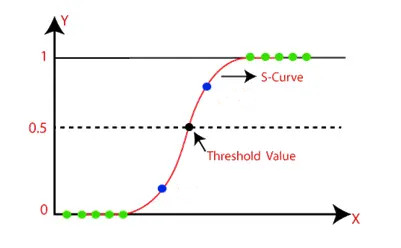

## **Composizione di funzioni**

Come per la regressione lineare, l'interpretazione della relazione tra featrue e label dipende dalla valutazione di determinati parametri (es. coeff. angolare e intercetta). In questo caso, però non avremo più una sola funzione da trattare ma una funzione composta.
\begin{align}
  f(g(x)) = y
\end{align}



1. La prima funzione è rappresentata dalla già nota equazione lineare.
   I suoi parametri (coeff. angolare e intercetta) ci daranno il criterio matematico con cui tracciare la linea di demercazione  tra le varie classi di appartenenza. Ad esempio, nel nostro caso, la linea passerà peresubimilmente tra il minimo dei valori appartenenti all'evento non verificato e il massimo dei valori restanti.
\begin{align}
  g(x) = z =  (ax + b)
\end{align}
Va da se che il coefficente angolare, in questo caso non aggiunge nulla al nostro modello. Quella che stiamo descrivendo è una retta parallela all'asse delle ascisse e il parametro che stiamo cercando ci darà l'offset della retta.
La notra equazione della retta avrà quindi più l'aspetto di una somma pesata.
\begin{align}
  g(x) = z =  (x + w)
\end{align}



2. La funzione logistica prenderà la posizione di ogni punto e stabilirà in base  alla posizione rispetto alla retta trovata, la probabilità di appartenenza ad una delle classi individuate.


\begin{align}
  f(z) = y = \frac{1}{1 + e^{-(x + w)}}  
\end{align}

In [ ]:

def linear_equation(x: np.array, w: float):
  return x  + w


def forward(x: np.array, w: float):
  z = linear_equation(x, w)
  return sigmoid(z)

## **Metodo della massima verosimiglianza**


Da qui in poi, cercheremo di capire come cotruire una sorta di **black-box** al cui interno una serie di passaggi comporranno il processo di classificazione.

La metodologia da usare l'abbiamo già afrontata durante la regressione lineare.
- Per prima cosa si cerca una funzione che restituisce l'errore ottenuto dall'applicazione del mio modello nel predirre o classificare.

- In seconda istanza si applica un metodo che ottimizza l'operazione di minimizzazione degli errori di predizione o classificazione.


Il metodo della **minimizzazione della funzione di costo** usato per la regressione lineare non potrebbe mai funzionare in questo caso.

Il risultato ottenuto fin qui non è rapprestnato da "distanze", ma da da una distribuzione di probablità in cui ad ogni "feature" è fondamentalmente associata una percentuale.

Attraverso il **metodo della massima verosimiglianza** si cerca quindi di ottenere un risultato di minimizzazione sul grado di avvicinamento alla classe di appartenenza per ogni valore processato.


Nello specifico andremo ad utilizzare la **funzione log-verosimilianza** (**log-loss function**).

\


\begin{align}
        l = \dfrac{1}{n} \sum_{i=1}^n (y_i \cdot log(ŷ_i) + (1 - y_i) \cdot log(1 - ŷ_i))
\end{align}




In [ ]:
def loss_log(x: np.array, y: np.array, a:float, b:float):
  y_hat = forward(x, a, b)
  return (y * np.log(y_hat)) + ( (1 - y) * np.log(1 - y_hat))


## **Discesa del gradiente**

Il concetto resta lo stesso già visto nella regressione lineare, naturalmente in questo caso si calcolano le derivate parziali della funzione di log-verosimiglianza.



# **La libreria scikit-learn**

In [ ]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()


# preparazione dei dati
px = prenotazioni.to_numpy().reshape(-1, 1)
ey = eventi.to_numpy()

test_prenotazioni = px[:5]
test_eventi       = ey[:5]

# training
logreg.fit(px, ey)


# test
test_classify = logreg.predict(test_prenotazioni)


print("EVENTI PREVISTI", test_classify)
print("EVENTI REALI", test_eventi)



EVENTI PREVISTI [1 0 0 0 1]
EVENTI REALI [1 0 0 0 1]


## **Training, Test**


Splittare in modo diretto questo tipo di dataset, non sembra una buona idea vediamo perhcé:

In [ ]:
eventi_count   = eventi_si.size + eventi_no.size
eventi_si_perc = float(eventi_si.size) / float(eventi_count)
eventi_no_perc = float(eventi_no.size) / float(eventi_count)

print(eventi_si_perc * 100)
print(eventi_no_perc * 100)

20.0
80.0


In [ ]:
from sklearn.model_selection import train_test_split


x_train, x_test, y_train, y_test = train_test_split(px, ey, test_size=0.2,  shuffle=True, random_state=42)

logreg.fit(x_train, y_train)


LogisticRegression()

## **Misurare l'errore di classificazione binaria**


Nel caso di una classificazione binaria, un metodi di verifica piuttosto efficiente è la costruzione della **matrice di confuzione**.

Durante il calcolo di questa matrice vengono rapportati i valori rali con i valori previsti in modo da dare quattro risultati disposti secondo il seguente schema:


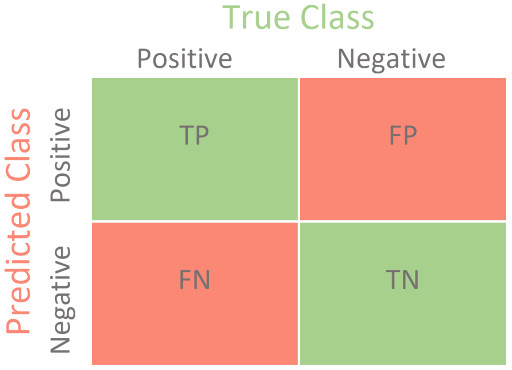

- **TP (True Positive)**:  numero dei campioni positivi correttamente previsti
- **TN (True Negative)**:  numero dei campioni negativi correttamente previsti
- **FP (False Positive)**: numero dei negativi erroneamente previsti come positivi
- **FN (False Negative)**: numero dei positivi erroneamente previsti come netagivi


Una volta ottenuta una **matrice di confusione**, risulterà molto più facile ricavarsi le misure per una valutazione generale.


- **TPR (True Positive Rate)**: $\frac{TP}{TP + FN}$

- **FPR (False Positive Rate)**: $\frac{FP}{FP + TN}$

- **Accuratezza (Accuracy)**: $\frac{TP + TN}{P + N} = \frac{Previsioni \ Corrette}{Totale \ Campioni}$

- **Precisione**: $\frac{TP}{TP + FP}$



**N.B. Quale misura scegliere?**

Non è una scelta scontata. Avere un buon tasso di risposte postive vere e false e quindi un buon grado di accuratezza, non è detto che sia la scelta più ottimale.

Ad esempio, nel nostro caso, vogliamo sapere quando il bar organizza eventi, quindi il tasso di campioni positivi corretti è molto più importante delle altre misure.

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = logreg.predict(x_test)

cm = confusion_matrix(y_test, y_pred)

print("True  Positive: ",  cm[0][0])
print("False Positive: ", cm[0][1])
print("\n")
print("True  Negative: ", cm[1][1])
print("False Negative: ", cm[1][0])

True  Positive:  14
False Positive:  0


True  Negative:  6
False Negative:  0
